In [2]:
from typing import Annotated, List, TypedDict, Literal
from pydantic import BaseModel, Field

In [3]:
class LLMJSON(BaseModel):
    query: str = Field(
        description="The generated query for web search",
    )
    
    

In [4]:
class LLMJSONFollow(BaseModel):
    follow_up_query: str = Field(
        description="The follow up query generated from the exisiting knowledge"
    )

In [5]:
class LLMJSONTitles(BaseModel):
    titles: list = Field(
        description="The generated list of titles for the course based on the exisiting summary or knowledge"
    )

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)
#llm_json_mode = ChatOpenAI(model="gpt-4-turbo", temperature=0, format="json")
llm_json_mode = llm.with_structured_output(LLMJSON, method="json_mode")
llm_json_mode_follow = llm.with_structured_output(LLMJSONFollow, method="json_mode")
llm_json_mode_title = llm.with_structured_output(LLMJSONTitles, method="json_mode")

In [140]:
import operator
from dataclasses import dataclass, field
from typing_extensions import TypedDict, Annotated

@dataclass(kw_only=True)
class SummaryState:
    research_topic: str = field(default=None) # Report topic     
    search_query: str = field(default=None) # Search query
    title_list: list = field(default=None)  
    contents: str = field(default=None) # Content of each title
    web_research_results: Annotated[list, operator.add] = field(default_factory=list) 
    sources_gathered: Annotated[list, operator.add] = field(default_factory=list) 
    research_loop_count: int = field(default=0) # Research loop count
    running_summary: str = field(default=None) # Final report
    title_count: int = field(default=0)
    

@dataclass(kw_only=True)
class SummaryStateInput:
    research_topic: str = field(default=None) # Report topic     

@dataclass(kw_only=True)
class SummaryStateOutput:
    running_summary: str = field(default=None) # Final report

@dataclass(kw_only=True)
class FinalReport:
    course_content: str = field(default=None)
    





In [141]:
query_writer_instructions="""Your goal is to generate a targeted web search query.
The query will gather information related to a specific topic.

<TOPIC>
{research_topic}
</TOPIC>

<FORMAT>
Format your response as a JSON object with ALL three of these exact keys:
   - "query": The actual search query string
   - "aspect": The specific aspect of the topic being researched
   - "rationale": Brief explanation of why this query is relevant
</FORMAT>

<EXAMPLE>
Example output:
{{
    "query": "machine learning transformer architecture explained",
    "aspect": "technical architecture",
    "rationale": "Understanding the fundamental structure of transformer models"
}}
</EXAMPLE>

Provide your response in JSON format:"""

summarizer_instructions="""
<GOAL>
Generate a high-quality summary of the web search results and keep it concise / related to the user topic.
</GOAL>

<REQUIREMENTS>
When creating a NEW summary:
1. Highlight the most relevant information related to the user topic from the search results
2. Ensure a coherent flow of information

When EXTENDING an existing summary:                                                                                                                 
1. Read the existing summary and new search results carefully.                                                    
2. Compare the new information with the existing summary.                                                         
3. For each piece of new information:                                                                             
    a. If it's related to existing points, integrate it into the relevant paragraph.                               
    b. If it's entirely new but relevant, add a new paragraph with a smooth transition.                            
    c. If it's not relevant to the user topic, skip it.                                                            
4. Ensure all additions are relevant to the user's topic.                                                         
5. Verify that your final output differs from the input summary.                                                                                                                                                            
< /REQUIREMENTS >

< FORMATTING >
- Start directly with the updated summary, without preamble or titles. Do not use XML tags in the output.  
< /FORMATTING >"""

reflection_instructions = """You are an expert research assistant analyzing a summary about {research_topic}.

<GOAL>
1. Identify knowledge gaps or areas that need deeper exploration
2. Generate a follow-up question that would help expand your understanding
3. Focus on technical details, implementation specifics, or emerging trends that weren't fully covered
</GOAL>

<REQUIREMENTS>
Ensure the follow-up question is self-contained and includes necessary context for web search.
</REQUIREMENTS>

<FORMAT>
Format your response as a JSON object with these exact keys:
- knowledge_gap: Describe what information is missing or needs clarification
- follow_up_query: Write a specific question to address this gap
</FORMAT>

<EXAMPLE>
Example output:
{{
    "knowledge_gap": "The summary lacks information about performance metrics and benchmarks",
    "follow_up_query": "What are typical performance benchmarks and metrics used to evaluate [specific technology]?"
}}
</EXAMPLE>

Provide your analysis in JSON format:"""


titles_generation_instructions = """"You goal is to generate list of titles  required to understand a  particular course by analyzing the given summary.

<SUMMARY>
{summary_data}
</SUMMARY>

<GOAL>
1. Generate high quality titles
2. Make sure not to repeat the titles
3. Generate more than 4 titles from the given summary
</GOAL>

<FORMAT>
Format your response as a JSON object with this one exact key:
    - "titles": The list of titles from the summary provided 
</FORMAT>

<EXAMPLE>
Example output:
{{
    "titles": ["Module 1: Understanding Microfinance Basics", "Module 2: The History and Evolution of Microfinance]
}}
Provide your analysis in JSON format:
"""

In [142]:
import json

from typing_extensions import Literal

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

from langgraph.graph import START, END, StateGraph
from langchain_core.runnables import RunnableConfig

In [143]:
import os
from dataclasses import dataclass, fields
from typing import Any, Optional

from langchain_core.runnables import RunnableConfig
from dataclasses import dataclass

from enum import Enum

class SearchAPI(Enum):
    PERPLEXITY = "perplexity"
    TAVILY = "tavily"
    DUCKDUCKGO = "duckduckgo"

@dataclass(kw_only=True)
class Configuration:
    """The configurable fields for the research assistant."""
    max_web_research_loops: int = int(os.environ.get("MAX_WEB_RESEARCH_LOOPS", "3"))
    fetch_full_page: bool = os.environ.get("FETCH_FULL_PAGE", "False").lower() in ("true", "1", "t")

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

In [144]:
import os
import requests
from typing import Dict, Any, List, Optional
from langsmith import traceable
from tavily import TavilyClient


def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=False):
    """
    Takes either a single search response or list of responses from search APIs and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()

def format_sources(search_results):
    """Format search results into a bullet-point list of sources.
    
    Args:
        search_results (dict): Tavily search response containing results
        
    Returns:
        str: Formatted string with sources and their URLs
    """
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_results['results']
    )



@traceable
def tavily_search(query, include_raw_content=True, max_results=3):
    """ Search the web using the Tavily API.
    
    Args:
        query (str): The search query to execute
        include_raw_content (bool): Whether to include the raw_content from Tavily in the formatted string
        max_results (int): Maximum number of results to return
        
    Returns:
        dict: Search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str): Full content of the page if available"""
     
    api_key = os.getenv("TAVILY_API_KEY")
    if not api_key:
        raise ValueError("TAVILY_API_KEY environment variable is not set")
    tavily_client = TavilyClient(api_key=api_key)
    return tavily_client.search(query, 
                         max_results=max_results, 
                         include_raw_content=include_raw_content)


In [145]:
from langchain_core.output_parsers import JsonOutputParser

In [146]:


def generate_query(state: SummaryState):
    """ Generate a query for web search """

    # Format the prompt
    query_writer_instructions_formatted = query_writer_instructions.format(research_topic=state.research_topic)

    # Generate a query
    result = llm_json_mode.invoke(
        [SystemMessage(content=query_writer_instructions_formatted),
        HumanMessage(content=f"Generate a query for web search:")]
    )
    
    query = result
    
    
    return {"search_query": query.query}

In [147]:
def web_research(state: SummaryState):
    """ Gather information from the web """

    
    search_results = tavily_search(state.search_query, include_raw_content=True, max_results=1)
    search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=True)
    
    return {"sources_gathered": [format_sources(search_results)], "research_loop_count": state.research_loop_count + 1, "web_research_results": [search_str]}

In [148]:
def summarize_sources(state: SummaryState):
    """ Summarize the gathered sources """

    # Existing summary
    existing_summary = state.running_summary

    # Most recent web research
    most_recent_web_research = state.web_research_results[-1]

    # Build the human message
    if existing_summary:
        human_message_content = (
            f"<User Input> \n {state.research_topic} \n <User Input>\n\n"
            f"<Existing Summary> \n {existing_summary} \n <Existing Summary>\n\n"
            f"<New Search Results> \n {most_recent_web_research} \n <New Search Results>"
        )
    else:
        human_message_content = (
            f"<User Input> \n {state.research_topic} \n <User Input>\n\n"
            f"<Search Results> \n {most_recent_web_research} \n <Search Results>"
        )

    # Run the LLM
    result = llm.invoke(
        [SystemMessage(content=summarizer_instructions),
        HumanMessage(content=human_message_content)]
    )

    running_summary = result.content
    return {"running_summary": running_summary}

In [149]:
def reflect_on_summary(state: SummaryState):
    """ Reflect on the summary and generate a follow-up query """

    result = llm_json_mode_follow.invoke(
        [SystemMessage(content=reflection_instructions.format(research_topic=state.research_topic)),
        HumanMessage(content=f"Identify a knowledge gap and generate a follow-up web search query based on our existing knowledge: {state.running_summary}")]
    )
    follow_up_query = result

    # Get the follow-up query
    query = follow_up_query.follow_up_query

    # JSON mode can fail in some cases
    if not query:

        # Fallback to a placeholder query
        return {"search_query": f"Tell me more about {state.research_topic}"}

    # Update search query with follow-up query
    return {"search_query": follow_up_query.follow_up_query}

In [150]:
def route_research(state: SummaryState, config: RunnableConfig) -> Literal["finalize_summary", "web_research"]:
    """ Route the research based on the follow-up query """

    configurable = Configuration.from_runnable_config(config)
    if state.research_loop_count <= int(configurable.max_web_research_loops):
        return "web_research"
    else:
        return "finalize_summary"

In [153]:

def finalize_summary(state: SummaryState):
    """ Finalize the summary """

    # Format all accumulated sources into a single bulleted list
    all_sources = "\n".join(source for source in state.sources_gathered)
    state.running_summary = f"## Summary\n\n{state.running_summary}\n\n ### Sources:\n{all_sources}"
    
    return {"running_summary": state.running_summary}

In [154]:
def create_titles(state: SummaryState):
    """ Create titles for the courses from the summary"""
    summary_made = state.running_summary
    result = llm_json_mode_title.invoke(
        [SystemMessage(content=titles_generation_instructions.format(summary_data=summary_made)),
        HumanMessage(content=f"Generate list of modules which would be required to make a course on this knowledge: {summary_made}")]
    )
    titles = result.titles
    all_sources = "\n".join(source for source in state.sources_gathered)
    content = titles
    return {"title_list": content}
    

In [155]:
def route_content(state: SummaryState):
    """Route back to content create if title_count is not 0"""

    print("Before routing title count", state.title_count)
    if state.title_count != 0:
        print("routing content create")
        state.title_count = state.title_count - 1
        print("After routing title count", state.title_count)
        return "Make more"
    else:
        print("Not routing")
        return "Finished"

In [168]:
def create_content(state:SummaryState):
    """Create content from the list of titles"""
    titles = state.title_list
    print("Titles", titles)
    state.title_count = len(titles)
    final_course_content = []
    for title in titles:
        # Format the prompt
        print("Title", title)
        query_writer_instructions_formatted = query_writer_instructions.format(research_topic=title)

        # Generate a query
        result = llm_json_mode.invoke(
            [SystemMessage(content=query_writer_instructions_formatted),
            HumanMessage(content=f"Generate a query for web search:")]
        )
        
        query = result
        

        # Call web search
        search_results = tavily_search(query.query, include_raw_content=True, max_results=1)
        search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=True)
        web_research_results = search_str
        #summarize the results
        
        existing_summary = ""

        # Most recent web research
        most_recent_web_research = web_research_results[-1]

        # Build the human message
        if existing_summary:
            human_message_content = (
                f"<User Input> \n {title} \n <User Input>\n\n"
                f"<Existing Summary> \n {existing_summary} \n <Existing Summary>\n\n"
                f"<New Search Results> \n {most_recent_web_research} \n <New Search Results>"
            )
        else:
            human_message_content = (
                f"<User Input> \n {title} \n <User Input>\n\n"
                f"<Search Results> \n {most_recent_web_research} \n <Search Results>"
            )

        # Run the LLM
        result = llm.invoke(
            [SystemMessage(content=summarizer_instructions),
            HumanMessage(content=human_message_content)]
        )

        result_generated = {
            "title": title,
            "content": result.content,
            "sources": [format_sources(search_results)]
        }

        print("Report =============================================")
        print("Title: ", title)
        print("Content: ", result.content)
        print("Sources: ", [format_sources(search_results)])
        print("END ===============================================\n")
        final_course_content.append(result_generated)
        
    # Format all accumulated sources into a single bulleted list
    all_sources = "\n".join(source for source in state.sources_gathered)
    final_output = f"### Summary\n\n{state.running_summary}\n\n ### Course Content\n\n{final_course_content} ### Sources:\n{all_sources}"
    return {"course_content": final_output}
    

In [ ]:
# Add nodes and edges
builder = StateGraph(SummaryState, input=SummaryStateInput, output=FinalReport, config_schema=Configuration)
builder.add_node("generate_query", generate_query)
builder.add_node("web_research", web_research)
builder.add_node("summarize_sources", summarize_sources)
builder.add_node("reflect_on_summary", reflect_on_summary)
builder.add_node("finalize_summary", finalize_summary)

builder.add_node("title_generation", create_titles)

builder.add_node("content_create",  create_content)




# Add edges
builder.add_edge(START, "generate_query")
builder.add_edge("generate_query", "web_research")
builder.add_edge("web_research", "summarize_sources")
builder.add_edge("summarize_sources", "reflect_on_summary")
builder.add_conditional_edges("reflect_on_summary", route_research)

builder.add_edge("finalize_summary", "title_generation")
builder.add_edge("title_generation", "content_create")
builder.add_edge("content_create", END)
graph = builder.compile()

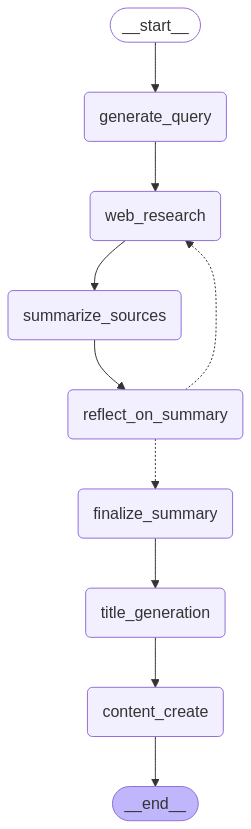

In [170]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [171]:
research_input = SummaryStateInput(research_topic="A microfinance course for beginners who need to learn from basics")
summary = graph.invoke(research_input)

Titles ['Introduction to Microfinance: Principles and Practices', 'The Role of Microfinance in Rural Development', 'Microfinance Institutions: Structure and Functionality', 'Impact Assessment of Microfinance on Economic Development', 'Microfinance Certification: Opportunities and Challenges', 'Exploring Microfinance Models from Global Institutions']
Title Introduction to Microfinance: Principles and Practices
Report =============================================
Title:  Introduction to Microfinance: Principles and Practices
Content:  Microfinance is a financial service provided to low-income individuals or those without access to typical banking services. It aims to empower these individuals by offering loans, savings, insurance, and training to help them start small businesses, thereby promoting financial inclusion and alleviating poverty. The principles of microfinance include providing opportunities for self-sufficiency, ensuring sustainability through financial self-service, and foc